In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

/Users/amritharaj/radioconda/envs/conda_env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [40]:
import opendatasets as od
import os

# === Step 1: Download dataset from Kaggle ===
# Replace the URL with your Alzheimer’s dataset link
kaggle_url = "https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset?select=AugmentedAlzheimerDataset"
root_dir   = "/Users/amritharaj/Desktop/venv-conda_env/Alzheimer_Project"

od.download(kaggle_url, root_dir)

# # === Step 2: Set paths ===
# # opendatasets will create a folder with the dataset name inside root_dir
# dataset_name = os.path.basename(kaggle_url).split('/')[-1]  # extracts <dataset-name>
# default_dir  = os.path.join(root_dir, dataset_name)

# train_dir = os.path.join(default_dir, "train")
# test_dir  = os.path.join(default_dir, "test")
# work_dir  = os.path.join(root_dir, "dataset")

# # === Step 3: Create working dir if needed ===
# if not os.path.exists(work_dir):
#     os.mkdir(work_dir)

# print("Train Directory:", train_dir)
# print("Test Directory:", test_dir)
# print("Working Directory:", work_dir)
# print("Working Directory Contents:", os.listdir(default_dir))

import os

root_dir = "/Users/amritharaj/Desktop/venv-conda_env/Alzheimer_Project"
dataset_dir = os.path.join(root_dir, "augmented-alzheimer-mri-dataset")  # no ?select=...

train_dir = os.path.join(dataset_dir, "train")
test_dir  = os.path.join(dataset_dir, "test")
work_dir  = os.path.join(root_dir, "dataset")

print("Train dir:", train_dir)
print("Test dir:", test_dir)
print("Work dir:", work_dir)
print("Contents:", os.listdir(dataset_dir))


Skipping, found downloaded files in "/Users/amritharaj/Desktop/venv-conda_env/Alzheimer_Project/augmented-alzheimer-mri-dataset" (use force=True to force download)
Train dir: /Users/amritharaj/Desktop/venv-conda_env/Alzheimer_Project/augmented-alzheimer-mri-dataset/train
Test dir: /Users/amritharaj/Desktop/venv-conda_env/Alzheimer_Project/augmented-alzheimer-mri-dataset/test
Work dir: /Users/amritharaj/Desktop/venv-conda_env/Alzheimer_Project/dataset
Contents: ['OriginalDataset', 'AugmentedAlzheimerDataset']


In [4]:
WORK_DIR = '/Users/amritharaj/Desktop/venv-conda_env/Alzheimer_Project/dataset'
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

IMG_SIZE   = 176
IMAGE_SIZE = [176, 176]
DIM        = (IMG_SIZE, IMG_SIZE)

In [5]:
ZOOM         = [0.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP    = True
FILL_MODE    = "constant"
DATA_FORMAT  = "channels_last"

In [6]:
work_dr = IDG(
    rescale=1./255,
    brightness_range=BRIGHT_RANGE,
    zoom_range=ZOOM,
    data_format=DATA_FORMAT,
    fill_mode=FILL_MODE,
    horizontal_flip=HORZ_FLIP
)

In [7]:
train_data_gen = work_dr.flow_from_directory(
    directory=WORK_DIR,
    target_size=DIM,
    batch_size=6500,
    shuffle=True
)

Found 40384 images belonging to 4 classes.


In [8]:
def show_images(generator, y_pred=None):
    labels = dict(zip([0, 1, 2, 3], CLASSES))
    x, y = generator.next()
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{}\nPredicted:{}".format(
                labels[np.argmax(y[i])], labels[y_pred[i]]))

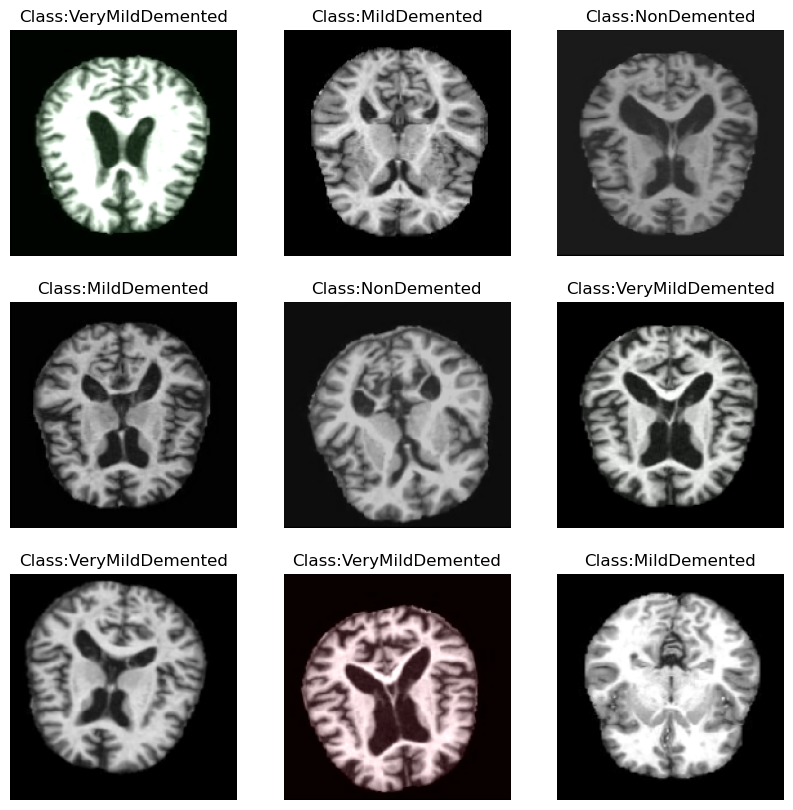

In [9]:
show_images(train_data_gen)

## Applying SMOTE (class balancing)

In [13]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(6500, 176, 176, 3) (6500, 4)


In [14]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(
    train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3),
    train_labels
)

In [16]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(8272, 176, 176, 3) (8272, 4)


## Train/val/test splits

In [17]:
train_data, test_data, train_labels, test_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)

## Model blocks

In [19]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Data Augmentation ---
train_idg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_idg = ImageDataGenerator(rescale=1./255)
test_idg = ImageDataGenerator(rescale=1./255)

In [20]:
def conv_block(filters, act='relu'):
    return Sequential([
        Conv2D(filters, 3, activation=act, padding='same', kernel_regularizer=l2(0.001)),
        Conv2D(filters, 3, activation=act, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.3)  # NEW dropout after conv block
    ])

In [21]:
def dense_block(units, dropout_rate, act='relu'):
    return Sequential([
        Dense(units, activation=act, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])

In [22]:
def construct_model(act='relu'):
    model = Sequential([
        Input(shape=(176,176,3)),
        
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.4),   # stronger dropout
        conv_block(256),
        Dropout(0.4),
        
        Flatten(),
        dense_block(512, 0.6),
        dense_block(128, 0.4),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')
    ], name="cnn_model")
    return model

In [23]:
model = construct_model()

In [24]:
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

## Metrics / compile

In [25]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=4)
]

In [27]:
from tensorflow.keras.optimizers.legacy import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, min_lr=1e-6)

In [29]:
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

## Train

In [30]:
history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=100,
    batch_size=32,   # reduced batch size for better generalization
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100


2025-09-10 16:26:48.000267: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


166/166 [==============================] - 113s 674ms/step - loss: 4.0206 - accuracy: 0.2603 - val_loss: 5.7678 - val_accuracy: 0.2477 - lr: 0.0010
Epoch 2/100
166/166 [==============================] - 116s 700ms/step - loss: 3.7438 - accuracy: 0.2751 - val_loss: 4.8713 - val_accuracy: 0.2462 - lr: 0.0010
Epoch 3/100
166/166 [==============================] - 105s 634ms/step - loss: 3.4821 - accuracy: 0.2855 - val_loss: 3.6497 - val_accuracy: 0.2606 - lr: 0.0010
Epoch 4/100
166/166 [==============================] - 110s 662ms/step - loss: 3.2408 - accuracy: 0.3297 - val_loss: 3.2762 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 5/100
166/166 [==============================] - 107s 645ms/step - loss: 3.0122 - accuracy: 0.3801 - val_loss: 3.7635 - val_accuracy: 0.2606 - lr: 0.0010
Epoch 6/100
166/166 [==============================] - 108s 653ms/step - loss: 2.7853 - accuracy: 0.4130 - val_loss: 5.5201 - val_accuracy: 0.2606 - lr: 0.0010
Epoch 7/100
166/166 [==============================]

## Plots (accuracy, loss)

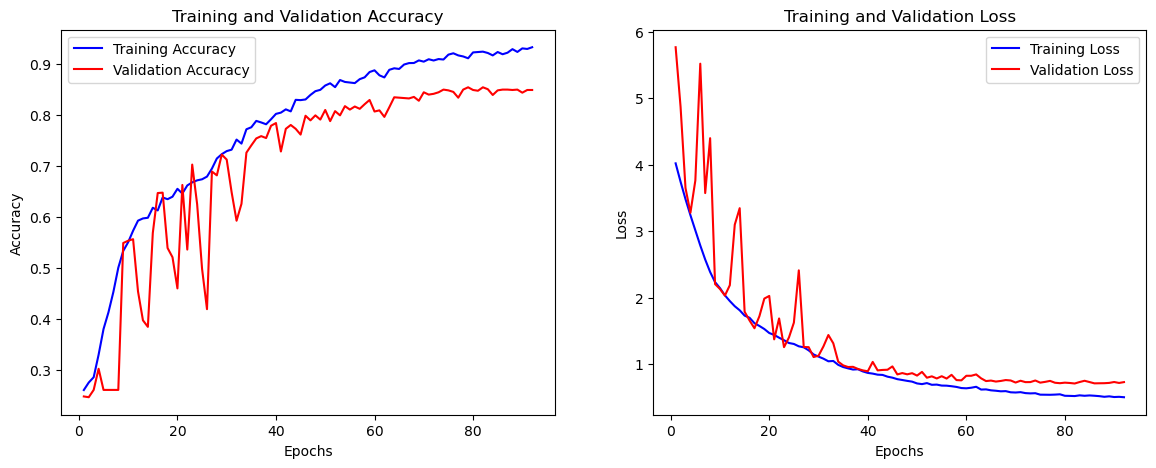

52/52 [==============================] - 8s 150ms/step - loss: 0.7158 - accuracy: 0.8544
Final Test Accuracy: 85.44%


In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call after training
plot_history(history)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=1)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")


## Evaluate

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")

52/52 [==============================] - 8s 149ms/step - loss: 0.8490 - acc: 0.7875 - auc: 0.9348 - f1_score: 0.7852
Test Accuracy: 78.75%


In [ ]:
pred_labels = model.predict(test_data)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

52/52 [==============================] - 8s 149ms/step


In [37]:
for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.85      0.89      0.87       418
VeryMildDemented       0.99      1.00      1.00       392
    MildDemented       0.82      0.79      0.81       413
ModerateDemented       0.75      0.75      0.75       432

       micro avg       0.85      0.85      0.85      1655
       macro avg       0.86      0.86      0.86      1655
    weighted avg       0.85      0.85      0.85      1655
     samples avg       0.85      0.85      0.85      1655



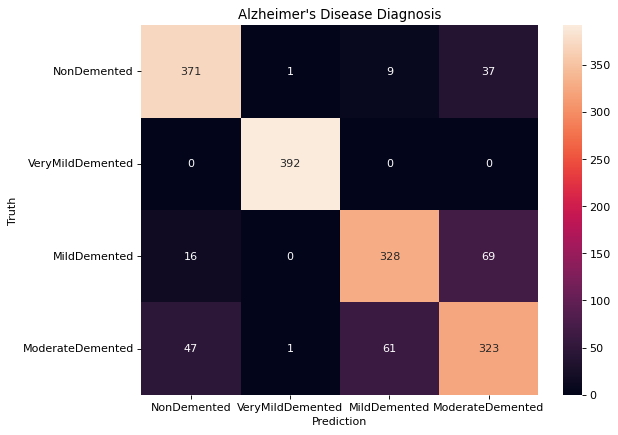

In [38]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)
conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(conf_arr, annot=True, fmt='d', xticklabels=CLASSES,
yticklabels=CLASSES)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [39]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("MCC: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 85.74 %
MCC: 80.59 %


In [41]:
model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']